<h1><b>Analysis goals</b>
<ol>
<li> What are the factors affecting price fluctuation for the airbnb? </li>
<li>Predict the price trend by training some algorithms</li>
<li>Exploratory data analysis on the review data</li>
</ol>

Importing libraries 

In [1]:
import pandas as pd
from datetime import date
import seaborn as sns
import numpy as np
import wordcloud as wc
import matplotlib as mat
from matplotlib import pyplot as plt
from pandas.api.types import CategoricalDtype
import sklearn as sk
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
# Check all the versions of the above packages.
print("Wordcloud version: {}".format(wc.__version__))
print("Numpy version: {}.".format(np.__version__))
print("scikit-learn version: {}.".format(sk.__version__))
print("Pandas version: {}.".format(pd.__version__))
print("Matplotlib version: {}.".format(mat.__version__))

Wordcloud version: 1.8.2.2
Numpy version: 1.21.6.
scikit-learn version: 1.0.2.
Pandas version: 1.3.5.
Matplotlib version: 3.2.2.


<h3><b> Analyse the calendar data</b></h3>

<h4> <b>Plan </b> </h4>
Step 1: load dataset <br>
Step 2:  Clean data <br>
Step 3:  Fill null values with 0, change price datype to float<br>
Step 4 Extract the year, month, and date, day_name from the date columns<br>
Step 5 :Change the way of presenting the boolean value; 1 if the value is 't'; 0 if 'f'; ignore the case.

In [8]:

#step 1 
calendar_raw_df = pd.read_csv('calendar.csv', parse_dates=['date'])
print(calendar_raw_df.info())

#step 2  and 3
calendar_raw_df['price'].replace('\$|,', '', regex=True, inplace=True)
calendar_raw_df['price'].fillna(0, inplace=True)
calendar_raw_df['price'] = calendar_raw_df['price'].astype('float')

# step 4
calendar_raw_df['year'] = calendar_raw_df['date'].dt.year
calendar_raw_df['month'] = calendar_raw_df['date'].dt.month
calendar_raw_df['day'] = calendar_raw_df['date'].dt.day
calendar_raw_df['day_name'] = calendar_raw_df['date'].dt.day_name()

#step 5 
calendar_raw_df['available'].replace({'t|T': 1, 'f|F': 0}, regex=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  object        
 3   price       934542 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB
None


In [9]:
calendar_raw_df.head()

,listing_id,date,available,price,year,month,day,day_name
0,241032,2016-01-04,1,85.0,2016,1,4,Monday
1,241032,2016-01-05,1,85.0,2016,1,5,Tuesday
2,241032,2016-01-06,0,0.0,2016,1,6,Wednesday
3,241032,2016-01-07,0,0.0,2016,1,7,Thursday
4,241032,2016-01-08,0,0.0,2016,1,8,Friday


<h4> EDA </h4>

(0.0, 400.0)

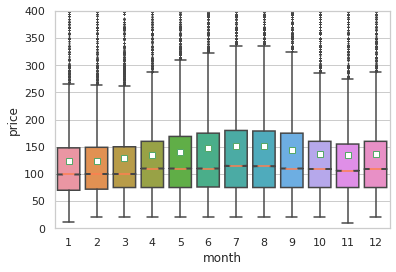

In [ ]:
""" 
Plan:
- select all available listing
- demonstrate the price distribution of each month, including the 
# average price, max/min price, and other metrics.

"""

avail_listing_cond = calendar_raw_df['available'] == 1 
avail_listing_df = calendar_raw_df.loc[avail_listing_cond, :]

sns.set_theme(style="whitegrid")

ax2_1 = sns.boxplot(data=avail_listing_df, x='month', y='price', fliersize=1, showmeans=True,
                    flierprops={"marker": "x"}, medianprops={"color": "coral"}, notch=True,
                    meanprops={"marker": "s", "markerfacecolor": "white"})
ax2_1.set_xticklabels(ax2_1.get_xticklabels())
ax2_1.set_ylim(0, 400)

**Insights from the boxplot:** 

- Average prices in summer holiday is higher than other periods of the year 
- NB: 
  - Orage line: median prices 
  - tiny white square is the average price

Text(0.5, 1.0, 'Distribution of listing from January to December')

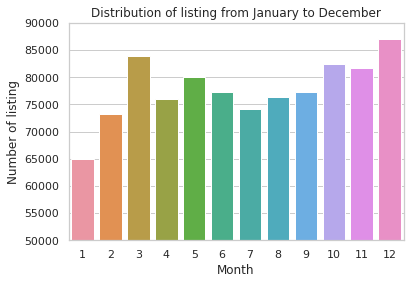

In [ ]:
# part 2: We can also display the number of the available listing.

list_mon_grouped = avail_listing_df.groupby('month').count()
ax2_2 = sns.barplot(x=list_mon_grouped.index.values, y=list_mon_grouped['listing_id'].values)
ax2_2.set_ylim(50000, 90000)
ax2_2.set_ylabel("Number of listing")
ax2_2.set_xlabel("Month")
ax2_2.set_title("Distribution of listing from January to December")

**Insights :** 

- Summer holiday period(June, July, August) and January have fewer available listings than the rest months of the year. Probably, customers have made the reservation in advance.

(135.0, 145.0)

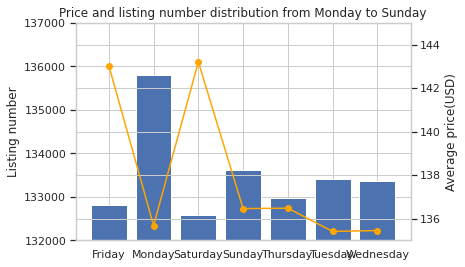

In [ ]:
"""
Plan:
 - Display the average price of listing on each day of the whole week
 - Plot a combo box of the distributions
"""
day_name_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avail_listing_df.loc[:, 'day_name'].astype(CategoricalDtype(day_name_list), copy=False)
list_wd_avg_grouped = avail_listing_df.groupby('day_name', as_index=False).mean()
list_wd_count_grouped = avail_listing_df.groupby('day_name', as_index=False).count()
list_wd_avg_grouped.sort_values('day_name')
list_wd_count_grouped.sort_values('day_name')

fig, ax2_3_a = plt.subplots()
ax2_3_a.bar(x=list_wd_avg_grouped['day_name'], height=list_wd_count_grouped['price'].values)
ax2_3_a.set_ylim(132000, 137000)
ax2_3_a.set_ylabel("Listing number")
ax2_3_a.set_title("Price and listing number distribution from Monday to Sunday")
ax2_3_b = ax2_3_a.twinx()
ax2_3_b.plot(list_wd_avg_grouped['price'].values, color='orange', marker='o')
ax2_3_b.set_ylabel("Average price(USD)")
ax2_3_b.set_xlabel("Day name")
ax2_3_b.set_ylim(135, 145)

**Insights:** 

✔ Monday has more available listings than the rest of the week.<br>
✔ For the average price, the average price for weekends (Friday & Saturday) is higher than the weekdays.


<h3><b> Analyse the Listings data</b></h3>

Plan:
- Load data 
- Clean 
- EDA - Correlations 
- Predict the trend and identify any issues 


In [4]:
#load the listing.csv file and check the info of the file


listing_raw_df = pd.read_csv('listings.csv')
print(listing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [6]:
"""
Plan 
 1 Check the information of the dataset
 2 Drop any columns contains URL because these columns are irrelevant to the room properties
 3 Drop entries missing price data since entries missing price data will lose their analytical value
 4 Setting up specific cleaning procedures for different types of columns
 5 Remove all the dollar signs or commas or % in these numeric-related columns
 6  covert `host_since`, `last_scraped`, `first_review`, `last_review` to float days
 7  Convert rates into float numbers
 8 Fill NaN cells with 0 on those numeric columns
 9 Fill NaN cells with "None" on those string columns
 10  Fill 1 or 0 for the boolean value

"""
#1
pd.set_option('display.max_columns', None)
print("There are {} entries in this dataset".format(listing_raw_df.shape[0]))
# print(listing_raw_df.head(10))

#2
url_list = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url','host_thumbnail_url', 
            'host_picture_url']
listing_df = listing_raw_df.drop(url_list, axis=1)

#3
listing_df.dropna(subset=['price'], inplace=True)

# 4 and 5  
numeric_column = ['price', 'weekly_price', 'monthly_price', 'cleaning_fee', 'extra_people',
                  'security_deposit', 'host_response_rate', 'host_acceptance_rate']
for numeric_col in numeric_column:
    listing_df[numeric_col].replace('\$|,|%', '', regex=True, inplace=True)
    listing_df[numeric_col] = pd.to_numeric(listing_df[numeric_col], errors="coerce", downcast='float').fillna(0)
#     listing_df[numeric_col].astype('float64', copy=False, errors="ignore")
print(listing_df.info())
#6 
today = date.today()
date_related_col = ['host_since', 'last_scraped', 'first_review', 'last_review']
for date_col in date_related_col:
    listing_df[date_col] = pd.to_datetime(today) - listing_df[date_col]

# 7
rate_column = ['host_response_rate', 'host_acceptance_rate']
for rate_col in rate_column:
    listing_df[rate_col] = listing_df[rate_col].apply(lambda x: round(x / 100, 2))

#8: 
num_listing_df = listing_df.select_dtypes(include=[int, np.float32, np.float64])
num_listing_df.fillna(0, inplace=True)
print(num_listing_df.info())

# 9 
str_listing_df = listing_df.select_dtypes(include=['object'])
str_listing_df.fillna('None', inplace=True)

# 10
boolean_column = ['host_has_profile_pic', 'host_is_superhost', 'host_identity_verified', 'has_availability',
                  'requires_license', 'instant_bookable', 'require_guest_profile_picture',
                  'require_guest_phone_verification']
for boolean_col in boolean_column:
    listing_df[boolean_col].replace({'t|T': 1, 'f|F': 0}, regex=True, inplace=True)

print("Done!")

There are 3818 entries in this dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 84 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   scrape_id                         3818 non-null   int64  
 2   last_scraped                      3818 non-null   object 
 3   name                              3818 non-null   object 
 4   summary                           3641 non-null   object 
 5   space                             3249 non-null   object 
 6   description                       3818 non-null   object 
 7   experiences_offered               3818 non-null   object 
 8   neighborhood_overview             2786 non-null   object 
 9   notes                             2212 non-null   object 
 10  transit                           2884 non-null   object 
 11  host_id                       

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   scrape_id                       3818 non-null   int64  
 2   host_id                         3818 non-null   int64  
 3   host_response_rate              3818 non-null   float64
 4   host_acceptance_rate            3818 non-null   float64
 5   host_listings_count             3818 non-null   float64
 6   host_total_listings_count       3818 non-null   float64
 7   latitude                        3818 non-null   float64
 8   longitude                       3818 non-null   float64
 9   accommodates                    3818 non-null   int64  
 10  bathrooms                       3818 non-null   float64
 11  bedrooms                        3818 non-null   float64
 12  beds                            38

<b> What are the correlations between the data points? </b> 

In [ ]:

"""
Plan 
 1 handling categorical variable: 'amenities' & 'host_verifications'
 2 Cleaning categorical values with special characters
 3 Create dummies for the `amenities` column and Create dummies for the 
 `host_verification` column
 4 Create dummies for other categorical value
 5 long explanation
 6 General view of the correlation between evaluation metrics and room properties
 7 The correlation between price and the room properties
 8 Correlation between reviews_rating and the room properties
 9  Question 2: Deep dive in the correlation in room amenities 
 10 correlation between `amenities` and `price` 
 11 correlation between `amenities` and `review_scores` 
 12 check the distribution of all value & the correlation heat map
 12 Explore the correlation between price and the other numeric value 
 13 Explore the correlation between review scores rating and the other numeric value

"""
#1 & 2
listing_df['amenities'].replace(r'[\{\}\"\']', '', regex=True, inplace=True)
listing_df['host_verifications'].replace(r'[\[\]\"\'\s]', '',regex=True,inplace=True)

#3
ame_split_df = listing_df['amenities'].str.split(',')
mlb = MultiLabelBinarizer()
ame_dummy = pd.DataFrame(mlb.fit_transform(ame_split_df), columns=mlb.classes_, index=ame_split_df.index)
ame_dummy.drop('', axis='columns', inplace=True)  # remove the column called ''.
room_prop_dummies = ame_dummy

# 3
hv_split_df = listing_df['host_verifications'].str.split(',')
hv_dummy = pd.DataFrame(mlb.fit_transform(hv_split_df), columns=mlb.classes_, index=hv_split_df.index)
hv_dummy.drop(['None', ''], axis='columns', inplace=True)
room_prop_dummies = room_prop_dummies.join(hv_dummy)

# 4 Create dummies for other categorical value
listing_cat_df = listing_df.select_dtypes(include=['object'])
listing_cat_count = listing_cat_df.nunique().sort_values(ascending=False)
print(listing_cat_count[listing_cat_count.between(2, 100, inclusive='both')])

# 5 
"""
 Then, we should select the features with analytical value and remove those columns with similar meanings.
 For example, "neighbourhood", "neighbourhood_cleansed", "neighbourhood_group_cleansed", these three
 columns have a similar meaning, but if we deep dive into these three columns, we will know,
 "neighbourhood_group_cleansed" is the outcome of the data cleaning process based on the first two columns.
 Also, Zipcode also represents the area of the house, which has a similar meaning to the neighbourhood,
 so, we should remove it, too.
"""

# 5 the categorical columns that we should put into analysis (manual selection):
analysis_col_list = ['property_type', 'neighbourhood_group_cleansed', 'host_response_time', 'bed_type',
                     'host_identity_verified', 'room_type', 'cancellation_policy', 'host_has_profile_pic',
                     'host_is_superhost', 'is_location_exact']
# Create dummies the features
other_feature_dummies = pd.get_dummies(listing_df[analysis_col_list], prefix_sep='_', drop_first=True, dummy_na=False)
room_prop_dummies = room_prop_dummies.join(other_feature_dummies)

print("Categorical data cleanning process finished!")

neighbourhood_cleansed          87
neighbourhood                   81
calendar_updated                34
zipcode                         28
neighbourhood_group_cleansed    17
property_type                   16
city                             7
smart_location                   7
bed_type                         5
host_response_time               4
room_type                        3
cancellation_policy              3
state                            2
is_location_exact                2
dtype: int64
Categorical data cleanning process finished!


<AxesSubplot:>

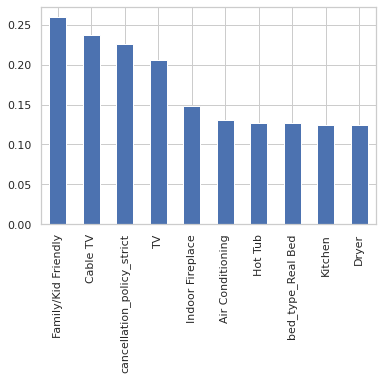

In [ ]:
# 6 General view of the correlation between evaluation metrics and room properties
# 7 The correlation between price and the room properties
prop_price_dum_df = room_prop_dummies.join(listing_df['price'])
prop_price_corr = prop_price_dum_df.corr()['price'].sort_values(ascending=False)
prop_price_corr.drop('price', inplace=True)
#7  Select the top 10 positive correlation features to display
prop_price_corr[prop_price_corr > 0].head(10).plot.bar()

**Evaluation criteria for correlations:**📌  <br>
<small style = "font-size:5;"> The range of corrleation: [-1, 1] <br>
No correlation: [-0.1, +0.1] <br>
Weak correlation: [-0.3~-0.1, 0.1~0.3] <br>
Medium correlation：[-0.5~-0.3, 0.3~0.5] <br>
Strong correlation: [-1~-0.5, 0.5~1] </small>

---------------------------------------------------------------------
**Insights from the plot:** 

- the feature of 'Family/kid friendly' has a strong correlation with the price
- common home appliances such as TV, and air conditioning might have the possibility of raising the listing price

--------------------------------------------------------------------


<AxesSubplot:>

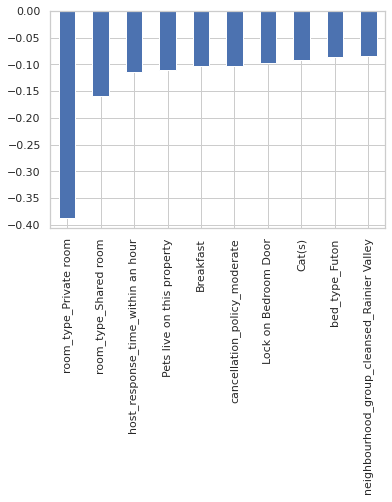

In [ ]:
# Select the top 10 negative correlation features to display 
prop_price_corr[prop_price_corr < 0].tail(10).sort_values().plot.bar()

**Insights:** 📌
- Room type has a limited impact on lowering the listing price. The other factors seem to have no effect on the price fluctuation.

<AxesSubplot:>

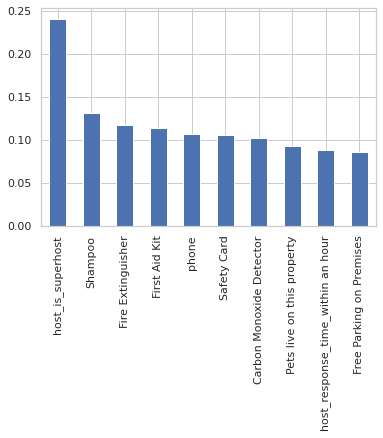

In [ ]:
# 8 Correlation between reviews_rating and the room properties
prop_review_dum_df = room_prop_dummies.join(listing_df['review_scores_rating'])
prop_review_corr = prop_review_dum_df.corr()['review_scores_rating'].sort_values(ascending=False)
prop_review_corr.drop('review_scores_rating', inplace=True)
# Select the top 10 positive correlation features to display 
prop_review_corr[prop_review_corr > 0].head(10).plot.bar()

**Insights :** 
- There is a weak correlation between whether the host is a super host and high review scores.
- Security facilities such as safety cards and smoke detectors might have the possiblities of improving customers' satisfaction.

<AxesSubplot:>

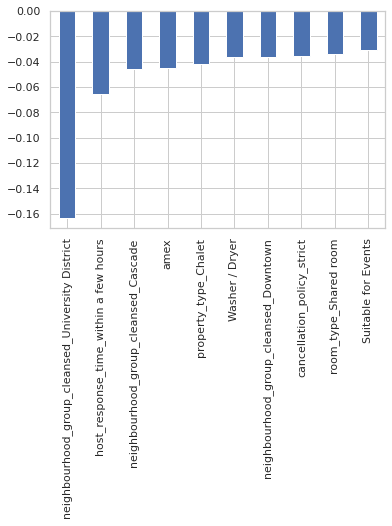

In [ ]:
# select the top 10 negative correlation features to display
prop_review_corr[prop_review_corr < 0].tail(10).sort_values().plot.bar()

**Insights from negative reviews:** 
- listing located in the University district has a limited influence on lowering the review rating.

<AxesSubplot:>

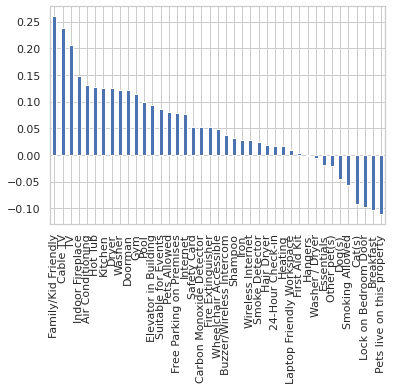

In [ ]:
# 9  Question 2: Deep dive in the correlation in room amenities 
# 10 correlation between `amenities` and `price` 
ame_price_dum_df = ame_dummy.join(listing_df['price'])
ame_price_corr = ame_price_dum_df.corr()['price'].sort_values(ascending=False)
ame_price_corr.drop('price', inplace=True)
ame_price_corr.plot.bar()

<AxesSubplot:>

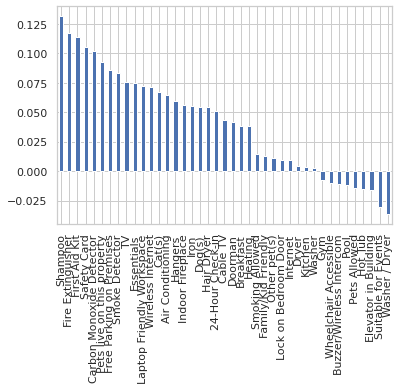

In [ ]:
# 11 correlation between `amenities` and `review_scores` 
ame_review_dum_df = ame_dummy.join(listing_df['review_scores_rating'])
ame_review_corr = ame_review_dum_df.corr()['review_scores_rating'].sort_values(ascending=False)
ame_review_corr.drop('review_scores_rating', inplace=True)
ame_review_corr.plot.bar()

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'scrape_id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_response_rate'}>,
        <AxesSubplot:title={'center':'host_acceptance_rate'}>,
        <AxesSubplot:title={'center':'host_is_superhost'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>],
       [<AxesSubplot:title={'center':'host_total_listings_count'}>,
        <AxesSubplot:title={'center':'host_has_profile_pic'}>,
        <AxesSubplot:title={'center':'host_identity_verified'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'price'}>,

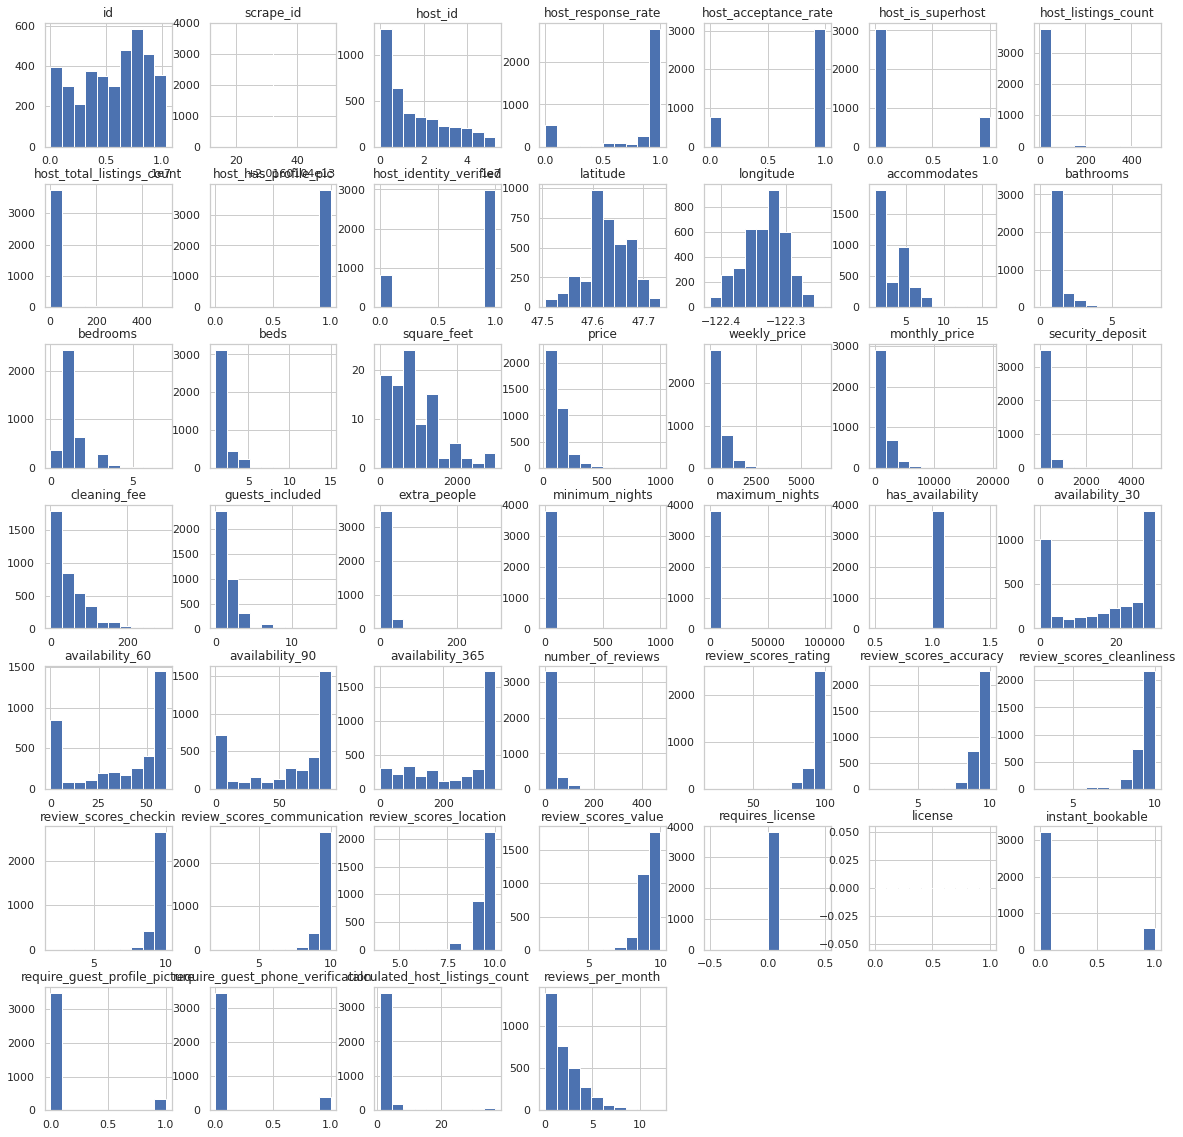

In [ ]:
# 12 check the distribution of all value & the correlation heat map
listing_df.hist(figsize=(20, 20))

<AxesSubplot:>

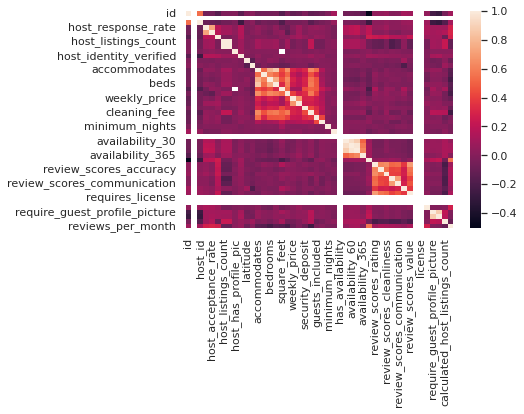

In [ ]:
#plot corr heatmap

sns.heatmap(listing_df.corr())

<AxesSubplot:>

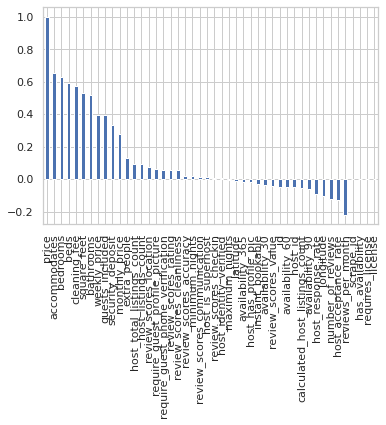

In [ ]:
# 12 Explore the correlation between price and the other numeric value 
listing_df.corr()['price'].sort_values(ascending=False).plot.bar()

**Insights :** 
-  The number of accommodation, the number of bedroom & beds, and cleaning fees has a significant effect on raising the listing price
-  It seems the monthly number of reviews has a week, negative correlation with the listing price. 

<AxesSubplot:>

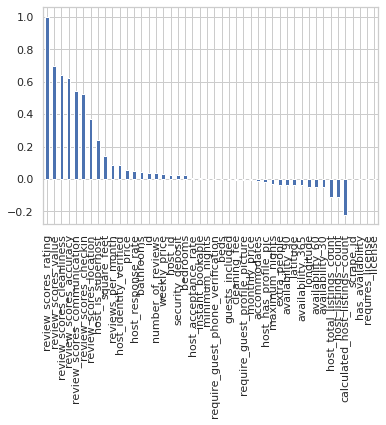

In [ ]:
# 13 Explore the correlation between review scores rating and the other numeric value
listing_df.corr()['review_scores_rating'].sort_values(ascending=False).plot.bar()

**Insights:** The reviews score in detail has a strong correlation with the review score rating.

(0.0, 500.0)

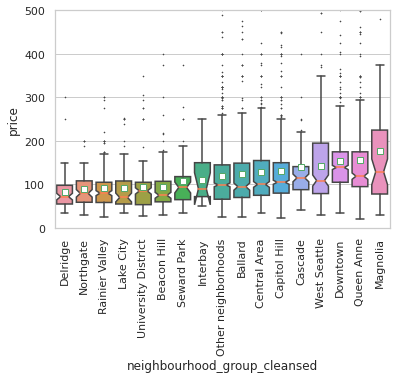

In [ ]:
order = listing_df.groupby(['neighbourhood_group_cleansed'])['price'].mean().sort_values().index.values
sns.boxplot(data=listing_df, x='neighbourhood_group_cleansed', y='price', fliersize=1, showmeans=True,
            flierprops={"marker": "x"}, medianprops={"color": "coral"}, notch=True, order=order,
            meanprops={"marker": "s", "markerfacecolor": "white"})
plt.xticks(rotation=90)
plt.ylim(0, 500)

**Insights**:
- Magnolia district has the most expensive listing price in Seattle and Deliridge district has the cheapest one
<small><i> ( most of the listing prices fluctuated between 100 dollars and 200 dollars)<i><small>

**Model Training** 



In [ ]:
"""
Plan: 
 1 Split the dataset into train and test dataset
 2 Model parameters setting
 3 Building a pipeline and set parameters for both models
 4 Display the feature importance, print out the top 20 positive factors of
  raising the price and print out the top 20 negative factors of lowering the price
"""



# 1 
X_train, X_test, y_train, y_test = train_test_split(train_df, y_for_price_df, random_state=1)
# For the price prediction, I choose random forest regression and Lasso regression algorithm
# 2 
lr_model = Lasso(random_state=1, fit_intercept=True, selection='random', max_iter=5000)
rfr_model = RandomForestRegressor(random_state=1)
select_lr = SelectFromModel(lr_model, threshold="median")
select_rfr = SelectFromModel(rfr_model, threshold="median")

# 3 Building a pipeline and set parameters for both models 
para_grid = [{'classifier': [rfr_model], 'preprocessing': [None], 'PolyFeatures': [None],
              'feature_selection': [select_rfr], 'classifier__n_estimators': np.arange(50, 150, 10),
              'classifier__max_depth': [3, 4, 5]},
             {'classifier': [lr_model], 'preprocessing': [StandardScaler()],
              'PolyFeatures': [PolynomialFeatures(degree=2)], 'feature_selection': [select_lr],
              'classifier__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
             ]
pipe = Pipeline([('preprocessing', StandardScaler()), ('feature_selection', select_lr),
                 ('PolyFeatures', PolynomialFeatures(degree=2)), ('classifier', lr_model)])
grid = GridSearchCV(pipe, param_grid=para_grid, cv=5, n_jobs=-1, scoring='r2')
grid.fit(X_train, y_train)

y_pred_train = grid.predict(X_train)  # Predict output on train dataset 
y_pred_test = grid.predict(X_test)  # Predict output on test datatset 

print("R2 score of train dataset = {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 score of test dataset = {:.3f} ".format(r2_score(y_test, y_pred_test)))

print("best_estimator setting:{}".format(grid.best_score_))
print("Best parameters:{}".format(grid.best_params_))
print("Best scorer:{}".format(grid.scorer_))

print("Finish!")


R2 score of train dataset = 0.773
R2 score of test dataset = 0.588 
best_estimator setting:0.5900445460048088
Best parameters:{'PolyFeatures': PolynomialFeatures(), 'classifier': Lasso(alpha=1, max_iter=5000, random_state=1, selection='random'), 'classifier__alpha': 1, 'feature_selection': SelectFromModel(estimator=Lasso(alpha=1, max_iter=5000, random_state=1,
                                selection='random'),
                threshold='median'), 'preprocessing': StandardScaler()}
Best scorer:make_scorer(r2_score)
Finish!


**Insights from the model :**
- the best estimator is the Lasso regression
- The R2 score of the training dataset is 0.773 and R2 score of the test dataset is 0.588
- This algorithm seems to overfit the data( we will retraing the model with better estimator params)




Traning Data: r-sqaured score: 0.627
Testing Data: r-sqaured score: 0.583


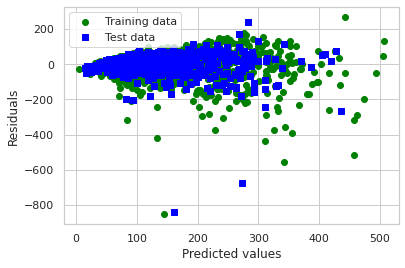

In [ ]:
# Retrain this dataset with using the best estimator parameters
X_train, X_test, y_train, y_test = train_test_split(train_df, y_for_price_df, random_state=1)
lasso_model = Lasso(alpha=1, max_iter=15000, fit_intercept=True, selection='random', random_state=1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
lasso_model.fit(X_train, y_train)
y_test_pred = lasso_model.predict(X_test)
y_train_pred = lasso_model.predict(X_train)

# Print out the result and visualization
print('Traning Data: r-sqaured score: %.3f' % r2_score(y_train, y_train_pred))
print('Testing Data: r-sqaured score: %.3f' % r2_score(y_test, y_test_pred))

plt.scatter(y_train_pred,  y_train_pred - y_train,c='green', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='blue', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

**Findings:** <br>
- From the above diagram, we can see the performance in predicting values below 300 is pretty good, when the price is more than 300, the accuracy of predicting the price has a significant drops due to insufficient data samples for models to learn the trend.

In [ ]:
# 4 Display the feature importance
print(lasso_model.coef_)
print(train_df.columns)
data = np.array([train_df.columns, lasso_model.coef_]).T
feature_importance_df = pd.DataFrame(data,columns=['Feature name', 'coef'])
#4 print out the top 20 positive factors of raising the price
print(feature_importance_df.sort_values('coef', ascending=False).head(20))
#4 print out the top 20 negative factors of lowering the price
print(feature_importance_df.sort_values('coef', ascending=True).head(20))

[-1.12553401e+00 -8.75848742e+00  1.85111919e+01  1.43918607e+01
  2.18286637e+01  8.87925994e-01  0.00000000e+00  0.00000000e+00
  9.24377219e-02  1.32271748e+00  0.00000000e+00  9.42883699e-02
  1.72319809e+00 -3.59147932e+00 -0.00000000e+00  1.47570506e+00
 -0.00000000e+00  5.65178811e-01  0.00000000e+00  0.00000000e+00
 -4.40165413e-01 -0.00000000e+00  4.62052421e+00 -0.00000000e+00
  2.15227780e+00 -1.74738634e-01 -0.00000000e+00 -6.12166123e-01
  0.00000000e+00 -5.79800546e-01  0.00000000e+00 -0.00000000e+00
 -2.76922780e+00 -0.00000000e+00  1.37931613e+00  5.09328933e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.12230307e-01
 -2.42840842e-01  9.47570926e-01  0.00000000e+00 -1.00153161e-01
 -1.85583332e+00  1.87147945e+00  0.00000000e+00 -9.22126106e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.05691273e+00  0.00000000e+00  0.00000000e+00  4.31192095e-02
  0.00000000e+00 -0.00000

<h3><b> Analyse the Reviews data</b></h3>

In [7]:
"""# Plan 
 1 Load the reviews.csv file and check the info of the dataset
 2 general data cleaning 
 3 fill Na value with "None" on Comments columns
 4 Generate "Year"、“Month"、”Day“ columns according to the date column
 5 Join the listing_df 

 
  """

#1 
reviews_df = pd.read_csv("reviews.csv", parse_dates=['date'])

# 2
# 3
reviews_df['comments'].fillna("None", inplace=True)
print(reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     84849 non-null  int64         
 1   id             84849 non-null  int64         
 2   date           84849 non-null  datetime64[ns]
 3   reviewer_id    84849 non-null  int64         
 4   reviewer_name  84849 non-null  object        
 5   comments       84849 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB
None


In [ ]:
# 4 
reviews_df['Year'] = reviews_df['date'].dt.year
reviews_df['Month'] = reviews_df['date'].dt.month
reviews_df['Day'] = reviews_df['date'].dt.day
reviews_df['day_name'] = reviews_df['date'].dt.day_name()

# 5
listing_join_list = ['id', 'price', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'cleaning_fee',
                     'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value']
review_info_df = pd.DataFrame(reviews_df.groupby('listing_id').count()['comments'].sort_values(ascending=False))
review_info_df = pd.merge(review_info_df, listing_df[listing_join_list], left_index=True, right_on='id')
review_info_df.rename({'comments': 'comment counts'}, axis=1, inplace=True)
print(review_info_df.head(10))

      comment counts      id  price neighbourhood_group_cleansed  \
1447             474  208356   89.0                     Downtown   
1441             466  365550   89.0                     Downtown   
3083             404   25002   75.0                      Ballard   
3600             353   47196   65.0                 Capitol Hill   
2568             320   63308   89.0                 Capitol Hill   
1499             319   92835   99.0                     Downtown   
2166             297    5682   48.0                     Delridge   
2690             294  279063   89.0                 Capitol Hill   
2456             287   53867   86.0          Other neighborhoods   
2668             279  841049   58.0                 Capitol Hill   

     property_type        room_type  cleaning_fee  review_scores_rating  \
1447          Loft     Private room           0.0                  95.0   
1441          Loft     Private room           0.0                  94.0   
3083         House  Entire

**Insights:** As the diagram shows, review scores in each aspect are more than 9.

 <h3> <b> Excecutive summary(Insights)</b> </h3> 
<ul style ="list-style-type: circle;" > <li>The average price for the summer holiday (June, July, and August) is higher than the other period of the whole year. The orange line represents the median value of price in that specific month</li>
<li>We can conclude that the summer holiday period(June, July, August) and January have fewer available listings than the rest months of the year. Probably, customers have made the reservation in advance.</li>
<li> Monday has more available listings than the rest of the week. For the average price, the average price for weekends (Friday & Saturday) is higher than the weekdays.</li>
<li>The number of accommodations, the number of bedrooms & beds, and cleaning fees have a significant effect on raising the listing price. Meanwhile, it seems the monthly number of reviews has a weak, negative correlation with the listing price.</li>

<h3><b>Blockers</b></h3>

The model I trained seemed to overfit the data, possible improvements in future.

